# Running a Polymer Welding Workflow with Hoomd-Organics

## Overview:
In this tutorial, we'll show a workflow that involves multiple steps of initializing a system and running simulations. In this case, part of initializing a system invovles running a simulation where the final structure of the simulaton serves as the input for the next round of system building and simulation.

**Specifically, the goal of this workflow is to model the fusion joining (i.e. welding) of two separate pieces of bulk polymer melt**. This requires that we have an equilibrated polymer melt system with at least 1 flat surface (i.e. where the periodic boundaries are eliminated). For the purposes of this tutorial, we will refer to this as a "slab". Once a slab structure has been created, we will create an interface system where two slabs are joined together, and run a fusion welding simulation. Finally, the welded system will be tested using a tensile test simulation.

In summary, this tutorial will go through the following workflow:

1. Initialize a new polymer system using poly(ethylene)
2. Run a simulation which yields an equilibrated poly(ethylene) slab
3. Build a system that is an interface between 2 poly(ethylene) slabs.
4. Run a fusion welding simulation
5. Run a tensile test simulation

The first step utilizes the same base classes dicussed in the introduction tutorial where we pull from `hoomd_organics.library.polymers` and `hoomd_organics.base.system` to build up poly(ethylen) chains and create an initial system. However, the rest of the workflow will use `hoomd_organics.modules.welding` and `hoomd_organics.library.simulations.tensile`.  These two modules inheret from the base `hoomd_organics.base.Simulation` class and contain additional features geared towards this specific workflow.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from hoomd_organics.library import PolyEthylene, OPLS_AA
from hoomd_organics import Pack
from hoomd_organics.modules.welding import SlabSimulation, Interface, WeldSimulation

from cmeutils.visualize import FresnelGSD
import gsd
import pickle
import unyt as u

### Step 1: Creating a "Slab"
In the next cell, we will initialize a new system with 30 chains of poly(ethylene) with each chain containing 12 repeat units. We'll use the `Pack` class from `hoomd_organics.base.system`.

**Note:**
1. For the sake of speeding up the simulation, hydrogen atoms will be removed (i.e. we'll run a "united atom" simulation) and charges won't be included in the simulation forcefield.

In [3]:
molecule = PolyEthylene(num_mols=30, lengths=12)

system = Pack(
    molecules=molecule,
    force_field=OPLS_AA(),
    density=1.1,
    r_cut=2.5,
    auto_scale=True,
    remove_charges=True,
    remove_hydrogens=True
)

#### `hoomd_organics.modules.welding.SlabSimulation`

In this cell, you'll notice we are not using `hoomd_organics.base.Simulation` but instead using `SlabSimulation`. This is a simulation class that inherits from `hoomd_organics.base.Simulation` but adds two additional features:

1. There is a parameter called `interface_axis` which determines which primary box face will be kept flat. This is required to create a interface system afterward.
2. hoomd wall forces (`hoomd.md.external.wall.LJ`) are how we can elimiate one of the periodic boundaries, create a flat surface. These forces are automatically added to the overall forcefield, and set up depending on the value used for `interface_axis`

**Note:**  

Since we are running multiple simulations we'll utilize python pickeling in order to re-use the Hoomd forcefield. There is a built-in method in the `Simulation` class which makes this step easier

In [5]:
sim = SlabSimulation.from_system(
    system=system,
    interface_axis=(1,0,0),
    gsd_file_name="slab_x_interface.gsd",
)

sim.pickle_forcefield()

No charged group detected, skipping electrostatics.
No charged group detected, skipping electrostatics.
Initializing simulation state from a snapshot.


Here, we can look at the complete set of forces that make up the forcefield. You'll notice that in addition to the typical forces of bonds, angles, dihedrals and pairs, there is also a `hoomd.md.external.wall.LJ` force as we would expect.

In [6]:
sim.forces

If we look at the details of the wall force we will notice two features:
1. Two walls are created where the origin for each is created along opposite ends of the x-axis of the simulation volume.
2. The forces of the walls point inward along the same axis.

In [7]:
for wall in sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", sim.box_lengths_reduced)

Plane(origin=_HOOMDTuple(17.74683380126953, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-17.74683380126953, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [35.4936676 35.4936676 35.4936676]


Similar to the introduction tutorial, we will use the `run_update_volume` method to reach a desired bulk density of $1.2 \dfrac{g}{cm^3}$. It is important we maintain the walls while the volume is updated. `hoomd_organics.base.Simulation` checks for the presence of wall forces when using `run_update_volume` and ensures the wall positions updated along with the box.

In [8]:
sim.run_update_volume(final_density=1.2*u.g/(u.cm**3), n_steps=5e4, kT=5.0, period=100, tau_kt=0.001)

Step 5500 of 50000; TPS: 3455.15; ETA: 0.2 minutes
Step 11000 of 50000; TPS: 3642.66; ETA: 0.2 minutes
Step 16500 of 50000; TPS: 3685.44; ETA: 0.2 minutes
Step 22000 of 50000; TPS: 3670.86; ETA: 0.1 minutes
Step 27500 of 50000; TPS: 3639.22; ETA: 0.1 minutes
Step 33000 of 50000; TPS: 3587.54; ETA: 0.1 minutes
Step 38500 of 50000; TPS: 3480.13; ETA: 0.1 minutes
Step 44000 of 50000; TPS: 3206.2; ETA: 0.0 minutes
Step 49500 of 50000; TPS: 2682.08; ETA: 0.0 minutes


Now that we reached the target bulk volume, we will run a `NVT` simulation using `run_NVT`. Normally, this step will be ran long enough to ensure equilibration, but for the sake of this tutorial we'll run for a small number of steps.

In [10]:
sim.run_NVT(kT=5.0, n_steps=2e4, tau_kt=0.001)

Step 4999 of 20000; TPS: 701.91; ETA: 0.4 minutes
Step 10499 of 20000; TPS: 704.96; ETA: 0.2 minutes
Step 15999 of 20000; TPS: 697.48; ETA: 0.1 minutes


#### Take a look a the polyethylene slab:

We can use a util from `cmeutils` that utilizes the [**Fresnel**](https://fresnel.readthedocs.io/en/v0.13.5/) python package under the hood to let us view the simulation trajectory in this notebook.

In this case, we are looking down the y-axis of the simulation volume, with the x-axis running left to right.

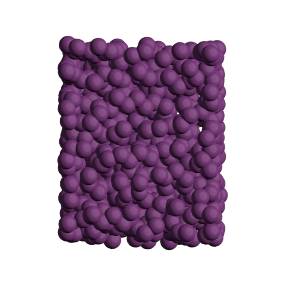

In [39]:
sim_viewer = FresnelGSD(gsd_file="slab_x_interface.gsd", view_axis=(0, 1, 0), frame=-1)
sim_viewer.view()

It is hard to tell if the flat surfaces we expect along the x-axis are there. We can use the unwrapped particle coordinates to better visualize the flat surfaces.  You'll notice that partciles are now going through the simulation volume in the z (up/down) and y (in/out) directions, but not the x (left/right) direction

**Note**
We'll adjust the height paramter to zoom out our view since the particle positions are outside the simulation volume

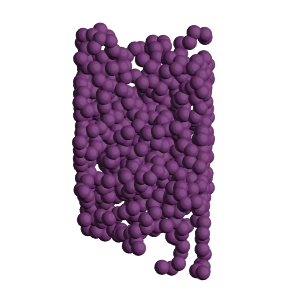

In [40]:
sim_viewer.unwrap_positions = True
sim_viewer.height += 2
sim_viewer.view()

sim_viewer.view_axis = (0, 1, 0)
sim_viewer.view()

### Step 2: Creating an interface from the slab



In [ ]:
interface = Interface(gsd_file="slab_x_interface.gsd", interface_axis=(1, 0, 0), gap=0.1)

In [ ]:
print(type(interface.hoomd_snapshot))
print("Slab number of particles:", system.n_particles)
print("Interface number of particles:", interface.hoomd_snapshot.particles.N)
print()
print("Slab box lengths:", sim.box_lengths_reduced)
print("Interface box lengths:", interface.hoomd_snapshot.configuration.box[:3])

### Step 3: Running a welding simulation



In [ ]:
weld_sim = WeldSimulation(initial_state=interface.hoomd_snapshot, forcefield=sim.forces[:5])

In [ ]:
weld_sim.forces

In [ ]:
for wall in weld_sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", weld_sim.box_lengths_reduced)

In [ ]:
weld_sim.run_NVT(kT=6.0, n_steps=5e4, tau_kt=0.001)